In [1]:
import jax
import jax.numpy as jnp
from jax.random import split
import flax
import flax.linen as nn

from einops import rearrange

import matplotlib.pyplot as plt

In [184]:
class Net(nn.Module):
    act = nn.relu

    @nn.compact
    def __call__(self, x):
        # print(x.shape)
        x = nn.Conv(32, (3, 3))(x)
        # print(x.shape)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        # print(x.shape)
        x = nn.relu(x)
        
        x = nn.Conv(32, (3, 3))(x)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        x = nn.relu(x)
        
        x = nn.Conv(32, (3, 3))(x)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        x = nn.relu(x)
        
        x = nn.Conv(32, (3, 3))(x)
        x = nn.avg_pool(x, (2, 2), strides=(2, 2))
        x = nn.relu(x)
        
        x = rearrange(x, '... h w c -> ... (h w c)')
        
        x = nn.Dense(10)(x)
        x = nn.relu(x)
        x = nn.Dense(1, kernel_init=jax.nn.initializers.ones, bias_init=jax.nn.initializers.zeros)(x)
        x = x[..., 0]
        return x
    
net = Net()

In [196]:
rng = jax.random.PRNGKey(0)
gridlen = 32

In [197]:
init_x = jnp.ones((gridlen, gridlen, 1))
rng, _rng = split(rng)
params = net.init(rng, init_x)

In [198]:
print(jax.tree_map(lambda x: x.shape, params))

{'params': {'Conv_0': {'bias': (32,), 'kernel': (3, 3, 1, 32)}, 'Conv_1': {'bias': (32,), 'kernel': (3, 3, 32, 32)}, 'Conv_2': {'bias': (32,), 'kernel': (3, 3, 32, 32)}, 'Conv_3': {'bias': (32,), 'kernel': (3, 3, 32, 32)}, 'Dense_0': {'bias': (10,), 'kernel': (128, 10)}, 'Dense_1': {'bias': (1,), 'kernel': (10, 1)}}}


In [199]:
def get_obs(y, x):
    obs = jnp.zeros((gridlen, gridlen, 1), dtype=jnp.float32)
    obs = obs.at[y, x].set(1.)
    return obs

In [200]:
y, x = jnp.arange(gridlen), jnp.arange(gridlen)
y, x = jnp.meshgrid(y, x, indexing='ij')

obs = jax.vmap(jax.vmap(get_obs))(y, x)
rew_map = jax.vmap(jax.vmap(net.apply, in_axes=(None, 0)), in_axes=(None, 0))(params, obs)

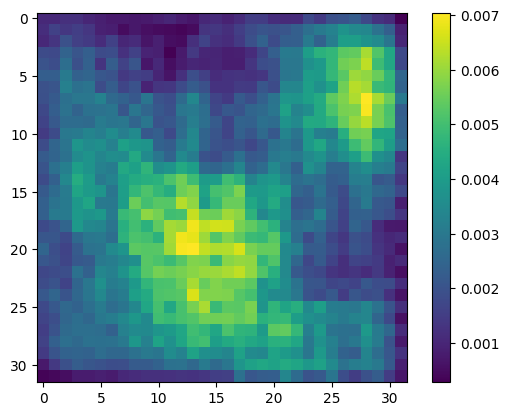

In [201]:
plt.imshow(rew_map)
plt.colorbar()

In [202]:
rew_map.mean(), rew_map.std()

(Array(0.00308404, dtype=float32), Array(0.00149857, dtype=float32))

In [203]:
params['params']['Dense_1']['kernel'] /= rew_map.std()
rew_map = jax.vmap(jax.vmap(net.apply, in_axes=(None, 0)), in_axes=(None, 0))(params, obs)
params['params']['Dense_1']['bias'] -= rew_map.mean()

In [204]:
y, x = jnp.arange(gridlen), jnp.arange(gridlen)
y, x = jnp.meshgrid(y, x, indexing='ij')

obs = jax.vmap(jax.vmap(get_obs))(y, x)
rew_map = jax.vmap(jax.vmap(net.apply, in_axes=(None, 0)), in_axes=(None, 0))(params, obs)

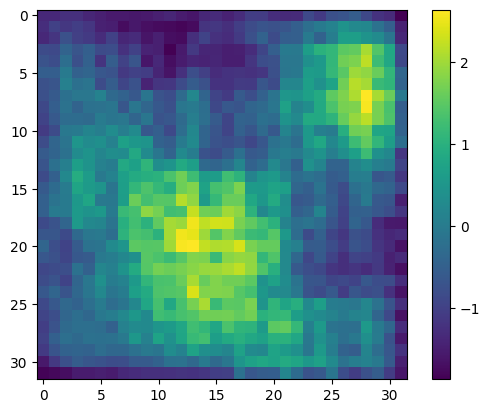

In [205]:
plt.imshow(rew_map)
plt.colorbar()

In [206]:
rew_map.mean(), rew_map.std()

(Array(2.225861e-07, dtype=float32), Array(1., dtype=float32))

In [207]:
rew_map.shape

(32, 32)

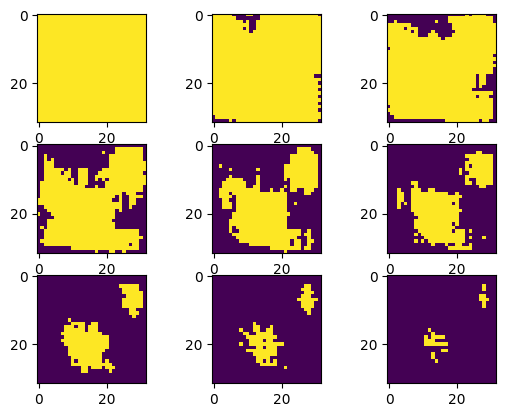

In [214]:
for i, thresh in enumerate(jnp.linspace(-2, 2, 9)):
    plt.subplot(3, 3, i+1)
    plt.imshow(rew_map>thresh, vmin=0, vmax=1)
    

In [222]:
rew_map = jax.random.uniform(rng, (16, 16))

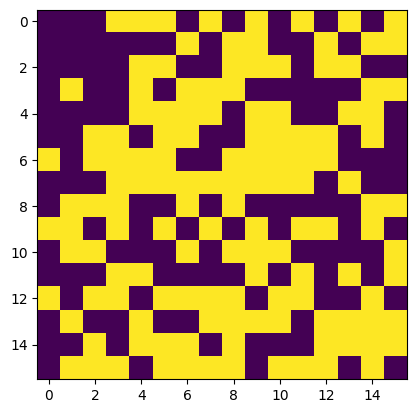

In [226]:
plt.imshow(rew_map>0.5, vmin=0, vmax=1)